# CNN - Custom W2V Embedding

Import Libraries:

In [1]:
import numpy as np
import os
import time
from datetime import datetime
import pandas as pd
import json
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import random as rn
import keras
from keras.initializers import Constant
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

startTime = time.time()
print("Tensor Flow Version: ",tf.__version__)

Using TensorFlow backend.


Tensor Flow Version:  2.2.0-rc2


In [2]:
#All this for reproducibility
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)

In [3]:
# Build the corpus and sequences
labelToName = { 0 : 'Rejected', 1 : 'Allowed' }
namesInLabelOrder = ['Rejected', 'Allowed']
os.chdir('D:\\PhD\\Dataset')
df=pd.read_csv('CriminalBailApplication.csv')
X=df.text.tolist()
labels=df.loc[:,['label']]


def preprocess(temp):
    temp=re.sub("\s\s+"," ",temp)    #Replacing multiple spaces with one
    temp=temp.replace(u'\xa0', ' ').encode('utf-8')  #Replacing non-breaking space    
    temp=temp.decode().split(' ')    #Converting a string into list of words seperated by space charcter
    return temp

#print(X[1])
X = [preprocess(t) for t in X]  
#print("\n\n\n After Preprocess:\n\n",X[1])

def seqlengths(l):
    if isinstance(l,list):
        yield len(l)
        for y in l:
            yield from seqlengths(y)

maxsequenceLength=max(seqlengths(X))
print("Max sequence length:",maxsequenceLength)

# Encode the documents
kTokenizer = keras.preprocessing.text.Tokenizer() 
kTokenizer.fit_on_texts(X)
Xencoded = np.array([np.array(xi) for xi in kTokenizer.texts_to_sequences(X)])                

print("Shape Before Padding:",np.shape(Xencoded[22]))
Xencoded=keras.preprocessing.sequence.pad_sequences(Xencoded, maxlen=maxsequenceLength, truncating='post')
print("\nShape After Padding:",np.shape(Xencoded[22]))

labels = np.array(labels)

nWords=len(kTokenizer.word_index)
print("\n nWords:",nWords)

Max sequence length: 1503
Shape Before Padding: (724,)

Shape After Padding: (1503,)

 nWords: 10203


In [4]:
EMBEDDING_DIM=200

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1).split(Xencoded, labels)
train_indices, test_indices = next(sss)
print(np.shape(train_indices))
print(np.shape(test_indices))

train_x = Xencoded[train_indices]
test_x = Xencoded[test_indices]
train_labels = keras.utils.to_categorical(labels[train_indices], len(labelToName))
test_labels = keras.utils.to_categorical(labels[test_indices], len(labelToName))

(309,)
(78,)


In [6]:
#Custom Embedding
filename = 'criminal_bail_embedding_word2vec.txt'
os.chdir('D:\\PhD\\Dataset')
embedding_index={}
f = open(os.path.join('',filename),encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs
f.close()

In [7]:
embedding_matrix = np.zeros((nWords+1, EMBEDDING_DIM))

for word, i in kTokenizer.word_index.items():
    if i > nWords+1:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        #word not found in embedding_index will be all zeros
        embedding_matrix[i] = embedding_vector

In [8]:
# Build the LSTM model
def getModel():
    units1, units2 = int (nWords/4), int (nWords/8)
    model = keras.models.Sequential()
    model.add(keras.layers.embeddings.Embedding(input_dim = nWords+1,
                                                output_dim = EMBEDDING_DIM,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxsequenceLength, 
                                                trainable=False))               
    model.add(keras.layers.Conv1D(128, 5, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    
    model.add(keras.layers.Dense(len(labelToName), activation ='softmax'))                           
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
    return model

In [9]:
# Train and test over multiple train/validation sets
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=False)                         
sss2 = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1).split(train_x, train_labels)          
results={}
for i in range(1):
    train_indices_2, val_indices = next(sss2)
    model = getModel()
    model.summary()
    history=model.fit(x=train_x[train_indices_2], y=train_labels[train_indices_2], epochs=50, batch_size=32, shuffle=True, validation_data = (train_x[val_indices], train_labels[val_indices]), verbose=2, callbacks=[early_stop], use_multiprocessing=True)
    test_loss, test_accuracy = model.evaluate(test_x, test_labels, verbose=2)                                
    print ("\ntest_loss:",test_loss, "\ntest_accuracy:",test_accuracy)
    predicted = model.predict(test_x, verbose=2)
    predicted_labels = predicted.argmax(axis=1)        
    print ("\n\nConfusion Matrix:\n",confusion_matrix(labels[test_indices], predicted_labels))
    print ("\n\nClassification Report:\n\n",classification_report(labels[test_indices], predicted_labels, digits=4, target_names=namesInLabelOrder))
    result={}
    result['confusion_matrix'] = confusion_matrix(labels[test_indices], predicted_labels).tolist()
    result['classification_report'] = classification_report(labels[test_indices], predicted_labels, digits=4, target_names=namesInLabelOrder, output_dict=True)
    results[i] = result
os.chdir('D:\\PhD\\Dataset\\Results\\Paper2')
filename = 'CNN-W2V-EMB-'+time.strftime("%d-%m-%Y-%H-%M-%S")+'.json'
f = open (filename,'w')
out = json.dumps(results, ensure_ascii=True)
f.write(out)
f.close()

endTime = time.time()
hours, rem = divmod(endTime-startTime, 3600)
minutes, seconds = divmod(rem, 60)
print("\n\nTotal time taken: ")
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1503, 200)         2040800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1499, 128)         128128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,169,186
Trainable params: 128,386
Non-trainable params: 2,040,800
_________________________________________________________________
Train on 247 samples, validate on 62 samples
Epoch 1/50
 - 3s - loss: 0.6887 - acc: 0.6883 - val_loss: 0.5759 - val_acc: 0.8226
Epoch 2/50
 - 3s - loss: 0.5014 - acc: 0.7854 - val_loss: 0.4561 - val_acc: 0.8065
Epoch 3/50
 - 4s - loss: 

In [10]:
print(len(history.history['acc']))
print(len(history.history['val_acc']))
print(len(history.history['loss']))
print(len(history.history['val_loss']))
print(len(history.history['acc']))

21
21
21
21
21


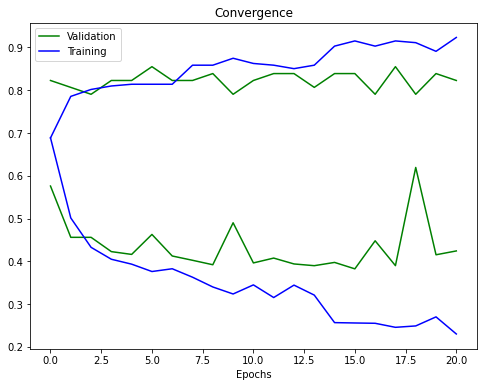

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1, 1, 1)

loss_train = history.history['loss']
loss_val = history.history['val_loss']

acc_train = history.history['acc']
acc_val = history.history['val_acc']

epochs = range(0,len(history.history['val_acc']))

subplot.plot(epochs,acc_val,color='g', label='Validation')
subplot.plot(epochs,loss_val,color='g')
subplot.plot(epochs,acc_train,color='b')
subplot.plot(epochs,loss_train,color='b', label='Training')

plt.title('Convergence')
plt.xlabel('Epochs')
#subplot.legend(loc='upper left', prop={'size': 9})
plt.legend()
plt.show()

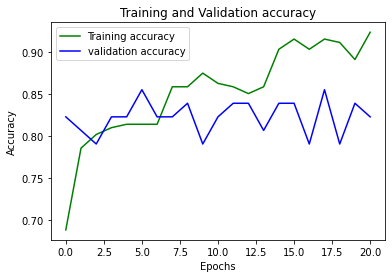

In [12]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(0,len(history.history['val_acc']))
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

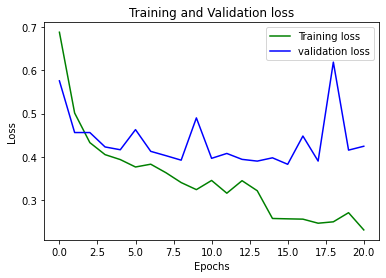

In [13]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,len(history.history['val_loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()